# Filtering fields


#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pysemtools

In [2]:
from pysemtools.io.ppymech.neksuite import pynekread
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

### Transforming the domain

It is important to transform the domain in such a way that the axis/plane of symmetry is on the zero coordinate.

In [3]:
msh = Mesh(comm, create_connectivity=True)
fld = FieldRegistry(comm)
pynekread('../data/rbc0.f00001', comm, data_dtype=np.double, msh=msh, fld=fld)
coef = Coef(msh, comm, get_area=False)




2025-05-13 16:04:15,125 - Mesh - INFO - Initializing empty Mesh object.
2025-05-13 16:04:15,126 - Field - INFO - Initializing empty Field object
2025-05-13 16:04:15,127 - pynekread - INFO - Reading file: ../data/rbc0.f00001
2025-05-13 16:04:15,139 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-05-13 16:04:15,139 - Mesh - INFO - Initializing common attributes.
2025-05-13 16:04:15,140 - Mesh - INFO - Getting vertices
2025-05-13 16:04:15,141 - Mesh - INFO - Getting edge centers
2025-05-13 16:04:15,151 - Mesh - INFO - Getting facet centers
2025-05-13 16:04:15,158 - Mesh - INFO - Creating connectivity
2025-05-13 16:04:15,565 - Mesh - INFO - Mesh object initialized.
2025-05-13 16:04:15,566 - Mesh - INFO - Mesh data is of type: float64
2025-05-13 16:04:15,567 - Mesh - INFO - Elapsed time: 0.427902383s
2025-05-13 16:04:15,567 - pynekread - INFO - Reading field data
2025-05-13 16:04:15,574 - pynekread - INFO - File read
2025-05-13 16:04:15,575 - pynekread - INFO - Elapsed ti

## Create the filter transfer function.

For this case, we can apply the same one that Nek5000 does. Check here, for example:

https://github.com/Nek5000/Nek5000/blob/d6ae08b6ee6bfe1d6e26003a5c94d8c41a6250d3/core/navier5.f#L166

https://nek5000.github.io/NekDoc/problem_setup/filter.html

Note that after you create the transfer functio in each direction. The correct format is a lx x lx matrix.

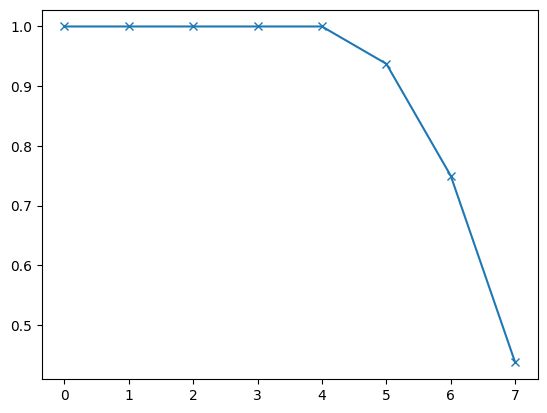

In [4]:
nx = msh.lx    # Plynomial order
wght = 1        # Weighting factor            
kut = 3         # Modes to cut off. This will attenuate last kut modes

# Create the transfer function
tf = np.ones(nx)
kut +=1
k0 = nx-kut
for k in range(k0+1,nx):
    kk = k
    amp = wght*(k-k0)*(k-k0)/(kut*kut)  
    tf[kk] = 1.-amp

# Truncate if the transfer function becomes negative
tf[tf < 0] = 0
# Make it a matrix
tf = np.diag(tf)

# Visualize the function to be applied
plt.plot(np.diag(tf), '-x')
plt.show()

### Build the filter

Then, simply proceed to build the filter based on the transfer function that you just created.

In this case, we will apply the same function in all 3 reference directions (r, s, t). If you want one direction to remain unfiltered, simply pass an identity matrix as transfer function

In [5]:
coef.build_spatial_filter(r_tf=tf, s_tf=tf, t_tf=tf)

2025-05-13 16:04:15,832 - Coef - INFO - Building spatial filter
2025-05-13 16:04:15,833 - Coef - INFO - 1d filters stored in the r_filter, s_filter and t_filter (if 3D) attributes


### Apply the filter

After the filters are built, it is very simple to apply them to a field

In [6]:
w = fld.registry["w"]
w_f = coef.apply_spatial_filter(w)

### Check the differences

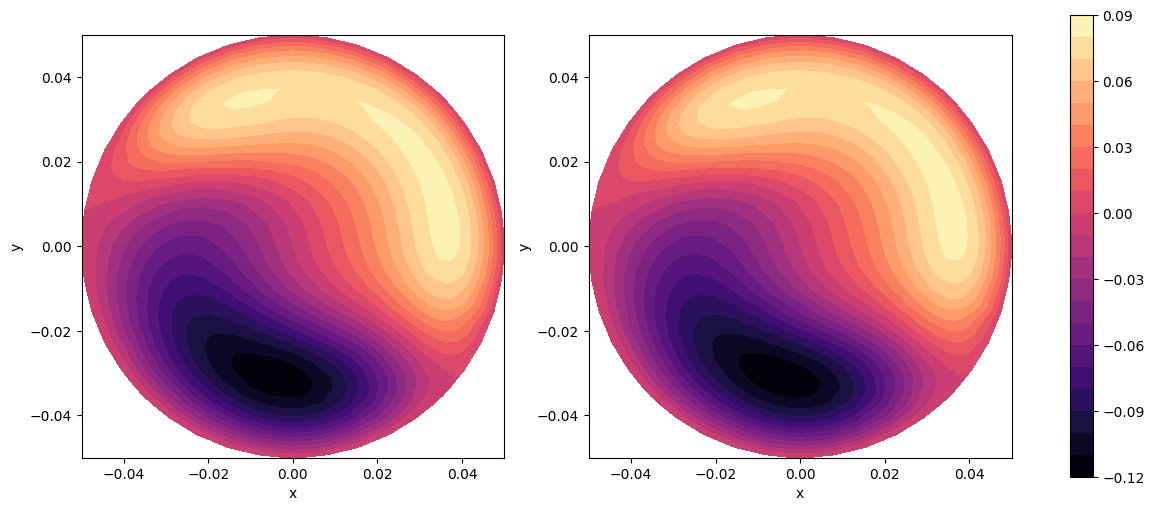

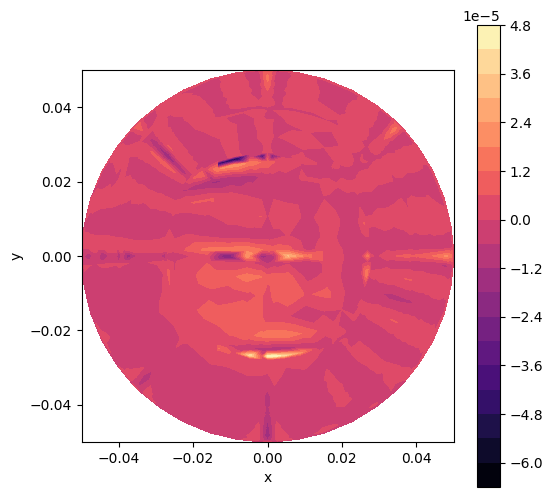

In [19]:
z_unique = np.unique(msh.z)
idx = 15

# Plot a slice to get a feel of the differences
x = msh.x[np.where(msh.z == z_unique[idx])]
y = msh.y[np.where(msh.z == z_unique[idx])]
w_ = w[np.where(msh.z == z_unique[idx])]
w_f_ = w_f[np.where(msh.z == z_unique[idx])]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
c0 = ax[0].tricontourf(x.flatten(), y.flatten(), w_.flatten(), levels=20, cmap='magma')
c1 = ax[1].tricontourf(x.flatten(), y.flatten(), w_f_.flatten(), levels=20, cmap='magma')
fig.colorbar(c0, ax=ax[:])
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
plt.show()
plt.show()

# Plot the difference
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
c0 = ax.tricontourf(x.flatten(), y.flatten(), (w_f_-w_).flatten(), levels=20, cmap='magma')
fig.colorbar(c0)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()